In [1]:
import pandas as pd
import numpy as np
from glob import glob 
import sys
sys.path += ["../src"]
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots as sbp
from sklearn.preprocessing import StandardScaler
import pickle


### Grid

In [20]:
def get_df_bins(df_, df_real, bin_size = 0.01):
    df = df_.copy()

    bins_x = np.arange(df_real["x"].min() - bin_size / 2, df_real["x"].max() + bin_size / 2, bin_size)
    bins_y = np.arange(df_real["y"].min() - bin_size / 2, df_real["y"].max() + bin_size / 2, bin_size)

    df["bin_x"] = pd.cut(df["x"], bins = bins_x, labels = np.arange(len(bins_x)-1))
    df["bin_y"] = pd.cut(df["y"], bins = bins_y, labels = np.arange(len(bins_y)-1))
    df.drop(columns = ["x", "y"], inplace = True)

    return df


In [ ]:
all_geo_features = {}

for file in sorted(glob(f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_*.pickle')):
    prov = file.split(".")[-2][-2:]

    all_geo_features[prov] = {}

    with open(file, 'rb') as f:
        data = pickle.load(f)

    df_real = get_df_bins(data["df_real"].copy(), data["df_real"])
    for k in data:
        if "95" not in k:
            df_k = get_df_bins(data[k], data["df_real"])
            dist = np.abs((df_real.groupby(["bin_x", "bin_y"]).mean() - df_k.groupby(["bin_x", "bin_y"]).mean()).dropna()).sum(axis = 1).mean()
            all_geo_features[prov][k] = dist

            

In [78]:
df_geo_features = pd.DataFrame(all_geo_features)
df_geo_features.to_csv(f"/data/housing/data/intermediate/jl_pop_synth/similarity_grid_geo_features_isp.csv")
df_geo_features = pd.read_csv(f"/data/housing/data/intermediate/jl_pop_synth/similarity_grid_geo_features_isp.csv", index_col = 0)
#df_geo_features = df_geo_features.drop("df_real").apply(lambda x: (x - x.mean()) / (x.std() + 0.0001))


In [79]:
df_geo_features.T.mean().sort_values()

df_real                     0.000000
df_copula_nf                0.528000
df_nfvae                    0.604806
df_copula_ablation          0.607509
df_shuffle_cap_num          0.609606
df_shuffle_cap_bins         0.628722
df_shuffle_province_num     0.745881
df_shuffle_province_bins    0.779049
df_ablation                 0.782489
dtype: float64

<Axes: >

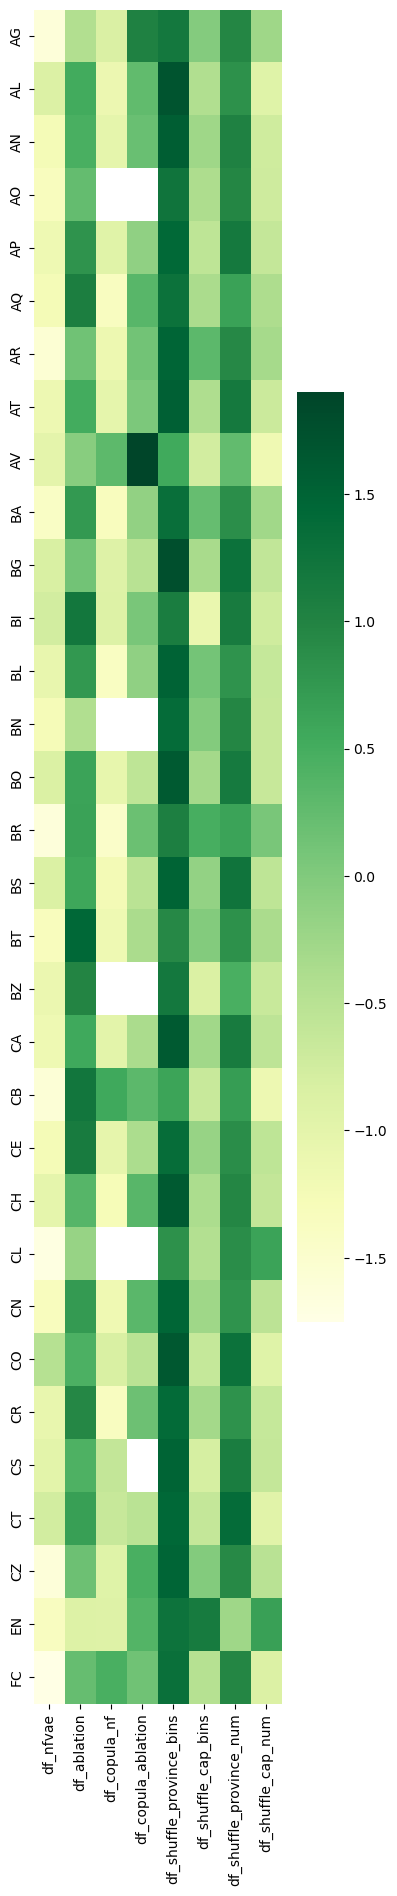

In [6]:
fig, axes = sbp(figsize = (4,22))

sns.heatmap(df_geo_features.T, cmap = "YlGn")

<Axes: xlabel='distance', ylabel='method'>

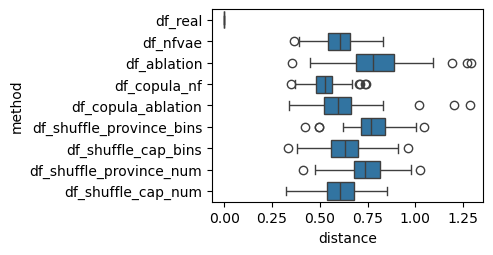

In [80]:
fig, axes = sbp(figsize = (3.5, 2.5))

sns.boxplot(data = df_geo_features.stack().reset_index().rename(columns = {"level_0": "method", 0: "distance"}), y = "method", x = "distance")

### Grid PCA

In [126]:
all_geo_features = {}

for file in sorted(glob(f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_*.pickle')):
    prov = file.split(".")[-2][-2:]

    all_geo_features[prov] = {}

    with open(file, 'rb') as f:
        data = pickle.load(f)

    pca = PCA(n_components = 27)
    pca.fit(data["df_real"].drop(columns = ["x", "y"]))
    n_components95 = (pca.explained_variance_ratio_.cumsum() < .95).sum()


    data_pca = {k: pd.concat([data[k][["x", "y"]], pd.DataFrame(pca.transform(data[k].fillna(0).drop(columns = ["x", "y"]))[:,:n_components95])], axis = 1) for k in data if "95" not in k}
    df_real = get_df_bins(data_pca["df_real"].copy(), data_pca["df_real"])

    for k in data:
        if "95" not in k:
            df_k = get_df_bins(data_pca[k], data_pca["df_real"])
            dist = (np.abs((df_real.groupby(["bin_x", "bin_y"]).mean() - df_k.groupby(["bin_x", "bin_y"]).mean()).dropna()).mean() * pca.explained_variance_ratio_[:n_components95]).sum()
            all_geo_features[prov][k] = dist

            

In [127]:
df_geo_features = pd.DataFrame(all_geo_features)
df_geo_features.to_csv(f"/data/housing/data/intermediate/jl_pop_synth/similarity_grid_geo_features_pca_isp.csv")
df_geo_features = pd.read_csv(f"/data/housing/data/intermediate/jl_pop_synth/similarity_grid_geo_features_pca_isp.csv", index_col = 0)
df_geo_features = df_geo_features.drop("df_real").apply(lambda x: (x - x.mean()) / (x.std() + 0.0001))


In [128]:
df_geo_features.T.mean().sort_values()

df_copula_nf               -1.023857
df_nfvae                   -0.897928
df_shuffle_cap_num         -0.601482
df_shuffle_cap_bins        -0.310407
df_copula_ablation         -0.115388
df_ablation                 0.732629
df_shuffle_province_num     0.934395
df_shuffle_province_bins    1.282039
dtype: float64

In [136]:
for k,file in enumerate(sorted(glob(f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_*.pickle'))):
    #for file in sorted(glob(f'/data/housing/data/intermediate/jl_pop_synth/airbnb_baselines/all_baselines_*.pickle')): # kill barcelona
    #moran_prov = {}

    prov = file.split(".")[-2].split("_")[-1]
    #print(prov)

    with open(file, 'rb') as f:
        data = pickle.load(f)
    print(k, prov, len(data["df_real"]))

    
            
    

0 AG 1181
1 AL 3542
2 AN 4252
3 AO 1455
4 AP 2633
5 AQ 1332
6 AR 4158
7 AT 1614
8 AV 1635
9 BA 17753
10 BG 13287
11 BI 1019
12 BL 1464
13 BN 1004
14 BO 13583
15 BR 3525
16 BS 10444
17 BT 4790
18 BZ 1588
19 CA 6370
20 CB 1127
21 CE 5258
22 CH 2858
23 CL 673
24 CN 3338
25 CO 7926
26 CR 2694
27 CS 2170
28 CT 3444
29 CZ 1386
30 EN 535
31 FC 3354
32 FE 2493
33 FG 4665
34 FI 18012
35 FM 1007
36 FR 1312
37 GE 13272
38 GO 1184
39 GR 2280
40 IM 2493
41 IS 245
42 KR 397
43 LC 4645
44 LE 6294
45 LI 2739
46 LO 2160
47 LT 3918
48 LU 3248
49 MB 11465
50 MC 2275
51 ME 2971
52 MI 52052
53 MN 2891
54 MO 4648
55 MS 1119
56 MT 1182
57 NA 20873
58 NO 5626
59 NU 575
60 OR 631
61 PA 5757
62 PC 1482
63 PD 12564
64 PE 2982
65 PG 8038
66 PI 3914
67 PN 2508
68 PO 4247
69 PR 3849
70 PT 4218
71 PU 3267
72 PV 3842
73 PZ 1427
74 RA 2082
75 RC 2031
76 RE 1920
77 RG 1806
78 RI 1402
79 RM 45823
80 RN 2240
81 RO 2162
82 SA 6574
83 SI 2657
84 SO 1267
85 SP 1554
86 SR 1595
87 SS 2652
88 SV 3860
89 TA 4802
90 TE 3256
91 T

In [134]:
len(data["df_real"])

45823

<Axes: xlabel='distance', ylabel='method'>

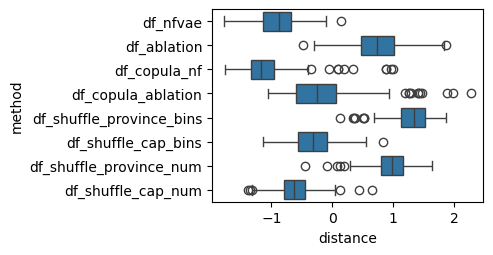

In [129]:
fig, axes = sbp(figsize = (3.5, 2.5))

sns.boxplot(data = df_geo_features.stack().reset_index().rename(columns = {"level_0": "method", 0: "distance"}), y = "method", x = "distance")

### Spatial autocorrelation

In [2]:
from spatial_autocorrelation import get_moransI, get_localMoransI
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import geopandas as gpd
from jl_synthetic_ipf_all_provinces import get_area_from_xy

from sklearn.decomposition import PCA

In [3]:
import jl_vae
geo_dict = jl_vae.load_geo_data()    

In [204]:
# compute Morans index
# W is the distance weight, can be modified 
def compute_spatial_autocorrelation(df, var, D = None, k = 20, local_moran = False, weighting = "within_CAP"):
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["x"], df["y"]), crs="EPSG:4326")
#    gdf = gdf.to_crs(epsg=3857)
    gdf = gdf.to_crs(gdf.estimate_utm_crs())

    if weighting == "within_CAP":
        cap = get_area_from_xy(df, geo_dict["cap"]).fillna(0)
        W = (np.array(cap.astype(int))[:,None] - np.array(cap.astype(int))[None,:] == 0) + 0.
    
    if weighting == "nearest_k":
        coords = np.array([(pt.x, pt.y) for pt in gdf.geometry])

        n = coords.shape[0]

        nn = NearestNeighbors(n_neighbors = k + 1, metric = "euclidean").fit(coords)
        dists, inds = nn.kneighbors(coords)         
        dists, inds = dists[:,1:], inds[:,1:] # remove self
            
        weights = np.exp(-dists / np.median(dists))
        
        row_idx = np.repeat(np.arange(n), k)
        col_idx = inds.ravel()
        w_ij = weights.ravel()

        W = csr_matrix((w_ij, (row_idx, col_idx)), shape=(n, n))

        # make symmetric by averaging (optional but common)
        W = 0.5 * (W + W.T)
        W = W.todense()

    if weighting == "dist_threshold":
        coords = np.array([(pt.x, pt.y) for pt in gdf.geometry])
        dists = pairwise_distances(coords)
        for k in range(len(dists)):
            dists[k,k] = np.inf
        threshold = np.percentile(dists, 1)
        W = (dists < threshold) + 0.
    
    if weighting == "exp":
        coords = np.array([(pt.x, pt.y) for pt in gdf.geometry])
        dists = pairwise_distances(coords)
        for k in range(len(dists)):
            dists[k,k] = np.inf
        
        W = np.exp(-dists / np.percentile(dists,1))
        W = W * (dists < np.percentile(dists,10))

    if local_moran:
        return get_localMoransI(W,np.array(df[var]), list(df.index))
    else:
        return get_moransI(W,np.array(df[var]))
    

In [ ]:
moran_pca = {k:compute_spatial_autocorrelation(data_pca[k], "feat", 
                                                 local_moran = False) for k in data_pca}

In [ ]:
# within_CAP 4.1 s 0.08
# nearest_k 4.2 s 0.31
# dist_threshold 4.7 s 0.08
# exp 6.2 s 0.07


{k:compute_spatial_autocorrelation(data_pca[k],  "feat", k = 20,
                                local_moran = False, weighting = "within_CAP") for k in data_pca}

{'df_real': 0.08487107,
 'df_nfvae': 0.05421028,
 'df_ablation': 0.01578484,
 'df_copula_nf': 0.01529221,
 'df_copula_ablation': 0.01989011,
 'df_shuffle_province_bins': 0.0069258,
 'df_shuffle_cap_bins': 0.08596767,
 'df_shuffle_province_num': 0.00560875,
 'df_shuffle_cap_num': 0.08264422}

In [252]:
moran_prov = {}

for file in sorted(glob(f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_*.pickle')):
    prov = file.split(".")[-2].split("_")[-1]
        
    with open(file, 'rb') as f:
        data = pickle.load(f)
    print(prov)
    print(len(data["df_real"]))

    pca = PCA(n_components = 1)
    pca.fit(data["df_real"].drop(columns = ["x", "y"]))
    #print(pca.explained_variance_)
    data_pca = {k: data[k][["x", "y"]].assign(feat = pca.transform(data[k].fillna(0).drop(columns = ["x", "y"]))[:,0]) for k in data if "95" not in k}

    moran_pca = {k:compute_spatial_autocorrelation(data_pca[k], "feat", 
                                                 local_moran = False) for k in data_pca}
    
    moran_prov[prov] = moran_pca




AG
1181
AL
3542
AN
4252
AO
1455
AP
2633
AQ
1332
AR
4158
AT
1614
AV
1635
BA
17753
BG
13287
BI
1019
BL
1464
BN
1004
BO
13583
BR
3525
BS
10444
BT
4790
BZ
1588
CA
6370
CB
1127
CE
5258
CH
2858
CL
673
CN
3338
CO
7926
CR
2694
CS
2170
CT
3444
CZ
1386
EN
535
FC
3354
FE
2493
FG
4665
FI
18012
FM
1007
FR
1312
GE
13272
GO
1184
GR
2280
IM
2493
IS
245
KR
397
LC
4645
LE
6294
LI
2739
LO
2160
LT
3918
LU
3248
MB
11465
MC
2275
ME
2971
MI
52052
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/jlenti/miniconda3/envs/synpop/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3667, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1559795/4281954060.py", line 16, in <module>
    moran_pca = {k:compute_spatial_autocorrelation(data_pca[k], "feat",
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_1559795/4281954060.py", line 16, in <dictcomp>
    moran_pca = {k:compute_spatial_autocorrelation(data_pca[k], "feat",
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_1559795/1542215252.py", line 53, in compute_spatial_autocorrelation
    return get_moransI(W,np.array(df[var]))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jlenti/miniconda3/envs/synpop/lib/python3.11/site-packages/spatial_autocorrelation/moransI.py", line None, in get_moransI
KeyboardInterrupt

During handling of the

In [37]:
dict_moran = {}
#weighting = "dist_threshold"
#weighting = "within_CAP"
#weighting = "nearest_k"
weighting = "exp"
for file in sorted(glob(f"/data/housing/data/intermediate/jl_pop_synth/spatial_autocorrelation/moran_*_pca.pkl")):
    prov = file.split(".")[-2].split("_")[-2]
    with open(file, "rb") as f:
        moran = pickle.load(f)
    dict_moran[prov] = moran[weighting]
df_moran = pd.DataFrame(dict_moran)

In [33]:
#df_moran.apply(lambda x: np.abs(x - x["df_real"]) / x.std()).T.to_csv(f"/data/housing/data/intermediate/jl_pop_synth/similarity_moran_{weighting}_isp.csv")

<Axes: xlabel="moran's I", ylabel='method'>

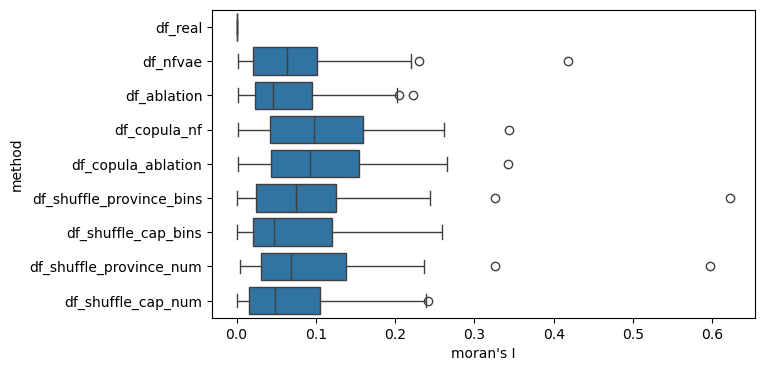

In [46]:
fig, axes = sbp(figsize = (7,4))

sns.boxplot(data = pd.DataFrame(df_moran).fillna(0).apply(lambda x: np.abs(x- x["df_real"])).stack().reset_index().rename(columns = {"level_0": "method", "level_1": "feature",0: "moran's I"}),
#sns.boxplot(data = pd.DataFrame(df_moran).fillna(0).stack().reset_index().rename(columns = {"level_0": "method", "level_1": "feature",0: "moran's I"}),
              x = "moran's I", y = "method")



In [75]:
pd.DataFrame((df_moran > 0.1) + 0.).T.corr()#apply(lambda x: (x - x.loc["df_real"])**2).mean(axis = 1)

,df_real,df_nfvae,df_ablation,df_copula_nf,df_copula_ablation,df_shuffle_province_bins,df_shuffle_cap_bins,df_shuffle_province_num,df_shuffle_cap_num
df_real,1.000000,0.334876,0.645497,NaN,NaN,0.161349,0.316933,0.215754,0.398996
df_nfvae,0.334876,1.000000,0.355335,NaN,NaN,0.202572,0.151204,0.240791,0.240791
df_ablation,0.645497,0.355335,1.000000,NaN,NaN,0.175412,0.218218,0.320508,0.228934
df_copula_nf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
df_copula_ablation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
df_shuffle_province_bins,0.161349,0.202572,0.175412,NaN,NaN,1.000000,-0.143542,0.815202,-0.180710
df_shuffle_cap_bins,0.316933,0.151204,0.218218,NaN,NaN,-0.143542,1.000000,-0.134885,0.794325
df_shuffle_province_num,0.215754,0.240791,0.320508,NaN,NaN,0.815202,-0.134885,1.000000,-0.169811
df_shuffle_cap_num,0.398996,0.240791,0.228934,NaN,NaN,-0.180710,0.794325,-0.169811,1.000000


In [49]:
df = data["df_real"].copy()
coords = np.asarray(df)
k = 10
if True:
    n = coords.shape[0]

    nn = NearestNeighbors(n_neighbors = k + 1, metric = "euclidean").fit(coords)
    dists, inds = nn.kneighbors(coords)         
    dists, inds = dists[:,1:], inds[:,1:] # remove self
        
    weights = np.exp(-dists / np.median(dists))
    
    row_idx = np.repeat(np.arange(n), k)
    col_idx = inds.ravel()
    w_ij = weights.ravel()

    W = csr_matrix((w_ij, (row_idx, col_idx)), shape=(n, n))

    # make symmetric by averaging (optional but common)
    W = 0.5 * (W + W.T)


In [34]:
df_ = data["df_real"]
D = pairwise_distances(np.array(df_[["x", "y"]]))

In [16]:
W = np.exp(-D)

In [41]:
k = 10
coords = np.asarray(data["df_real"][["x", "y"]])
n = coords.shape[0]

nn = NearestNeighbors(n_neighbors=k+1, metric="euclidean").fit(coords)
dists, inds = nn.kneighbors(coords)           # includes self at [:,0]
dists, inds = dists[:,1:], inds[:,1:] 

In [43]:
dists.shape

(13583, 10)

In [12]:
compute_spatial_autocorrelation(df_, "log_price")

0.99729852

In [21]:
import sklearn
print(sklearn.__version__)

1.2.2
